# Dynamic PET kinetic modeling example

Samuel Kuttner. 2024-09-24

samuel.kuttner@uit.no

## Background
Tissue compartment modeling is used to perform quantification in PET imaging. It requires at least one tissue curve and and an arterial input function (AIF).

## Aim
The purpose of this exercise is to learn how to perform tissue compartment modeling in Python using the reversible two tissue compartment model.

## Requirments
* You can work either using your local standard Python installation, or by using for example Google Colabs.

* Dataset

    The data for this exercise is available in this repository under ".../Example_data/".
  
    The data consists of two files:
    - The AIF of a mouse measured during 45 minutes with 1s sampling interval.
    - Tissue curves from four tissue regions: Brain, left ventricle, Liver and Myocardium.


Import necessary libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os

* If running local Jupiyther notebook, specify local data path as WDIR.

* If running on Colabs, specify the data path in your Google Drive folder
(as "/content/drive/My Drive/...")

In [2]:
if "Users" in os.getcwd():
  #Local runtime
  print("Local runtime")
  WDIR = "/Users/sku014/Library/CloudStorage/OneDrive-UiTOffice365/Research/Presentationer_Undervisning/Kurser/Physics in Nuclear Medicine Special Curriculum/Python demo/dPET_dcm_M3/"

elif "content" in os.getcwd():
  #Assume Colabs runtime
  #From: https://realpython.com/generative-adversarial-networks/
  #Mount google drive and set working directory (wdir)
  print("Colabs runtime")
  from google.colab import drive
  drive.mount('/content/drive/')
  WDIR = "/content/drive/My Drive/Jobb/PET_ML_Research/Kurs & Konferens/Physics in Nuclear Medicine Special Curriculum/"

else:
  # Data from Example_data folder
  print("Local runtime")
  WDIR = "./Example_data/"

PATH_AIF = WDIR + "AIF_shift_SUV_M3.txt"
PATH_VOI = WDIR + "VOIdata_M3.voistat"

Local runtime


Read the AIF data.

- `AIF_A` is the arterial input function in SUV, delay corrected (shifted) to match the PET data
- `AIF_t` is the time vector in minutes


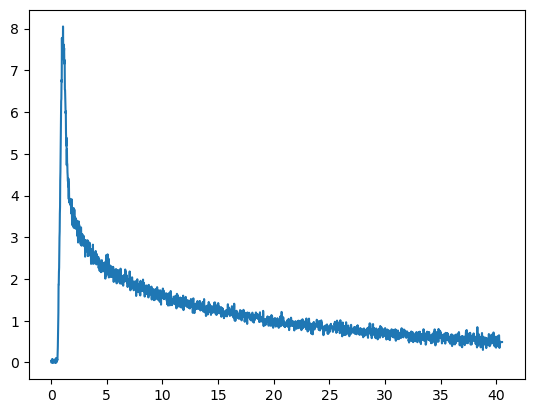

In [3]:
with open(PATH_AIF, "rb") as f:
    df = pd.read_csv(f, sep="\t")

COLS = df.columns

AIF_t = np.array(df.loc[:, [COLS[0]]]).squeeze()
AIF_t = (AIF_t - AIF_t[0])  # Zero shift
AIF_A = np.array(df.loc[:, [COLS[1]]]).squeeze()

plt.plot(AIF_t, AIF_A)

Read the VOI data. Exclude the 7 line header in the *.voistat file

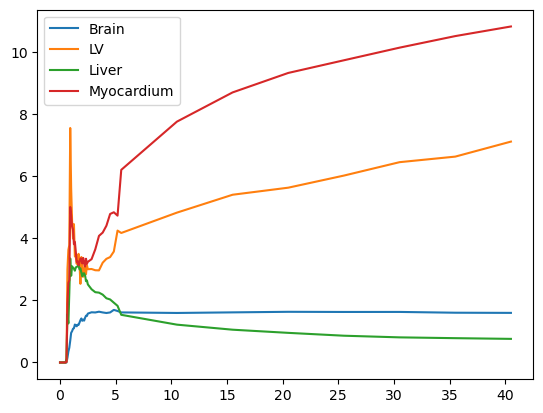

In [4]:
with open(PATH_VOI, "rb") as f:
    df = pd.read_csv(f, sep="\t", header=7)

COLS = df.columns


#VOI names
VOI_names = np.array(df.loc[:, [COLS[9]]]).squeeze()
VOI_names_unique, VOI_start_idx = np.unique(VOI_names, return_index=True)

#Number of time frames
num_frames = int(len(VOI_names) / len(VOI_names_unique))

# Add VOI data to dictionary
VOI_A_dict = {}

for idx, start_idx in enumerate(VOI_start_idx):
    start = start_idx
    end = start_idx + num_frames - 1
    VOI_A = np.array(df.loc[start:end, [COLS[11]]]).squeeze()
    VOI_A_dict.update({VOI_names_unique[idx]:VOI_A})

#Extract time from last VOI index (all times are equal by definition from PMOD!
VOI_t = np.array(df.loc[start:end, [COLS[10]]]).squeeze()

#Convert to frame start times (zero shift)
VOI_t_shift = np.zeros_like(VOI_t)
for idx, time in enumerate(VOI_t):
    if idx == 0:
        VOI_t_shift[idx] = 0
    else:
        VOI_t_shift[idx] = 2*VOI_t[idx-1] - VOI_t_shift[idx-1]

# Convert to minutes
VOI_t_shift = VOI_t_shift/60

#Plot VOI data
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[0]], label=VOI_names_unique[0])
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[1]], label=VOI_names_unique[1])
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[2]], label=VOI_names_unique[2])
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[3]], label=VOI_names_unique[3])
plt.legend()
plt.show()

Now it is time to define the functions for tissue compartment modeling (TCM). We will evaluate three different models, Reversible and irreversible two-tissue compartment model, and the Patlak model.

Thus, we need three functions:
1. An interpolation function that interpolates the AIF and VOI data to the same and constant time sampling, as well as shortens the longest to obtain equal length.

2. A function where the equations for the different models are defined.

3. An optimization function, using the `curve_fit` from the SciPy package.

In [5]:
from Tissue_compartment_modeling import (
    interpolate_time_frames,
    patlak,
    twoTCMirrev,
    twoTCMrev,
)

Perform TCM of all tissues in the `*.voistat`-file.

In [6]:

# TCM_dict will store all the resuts from kinetic modeling (k-values)
twoTCMrev_dict = {}
twoTCMirrev_dict = {}
patlak_dict = {}

# CONTINUE HERE: Loop over kinetic models

# Loop over the  tissues
for tissue in VOI_names_unique:
    print(tissue)

    # Reversible 2TCM
    (K1, k2, vB, k3, k4), Ki, tissue_fit, mse = twoTCMrev(
        AIF_A, AIF_t, VOI_A_dict[tissue], VOI_t_shift, INTERPOLATE=True, TIME_FRAMES=2.5
    )

    # Save everything into dictionary
    twoTCMrev_dict[tissue] = {
        "K1": K1,
        "k2": k2,
        "k3": k3,
        "k4": k4,
        "vB": vB,
        "Ki": Ki,
        "tissue_fit": tissue_fit,
        "mse": mse
    }

    # Irreversible 2TCM
    (K1, k2, vB, k3), Ki, tissue_fit, mse = twoTCMirrev(
        AIF_A, AIF_t, VOI_A_dict[tissue], VOI_t_shift, INTERPOLATE=True, TIME_FRAMES=2.5
    )

    # Save everything into dictionary
    twoTCMirrev_dict[tissue] = {
        "K1": K1,
        "k2": k2,
        "k3": k3,
        "vB": vB,
        "Ki": Ki,
        "tissue_fit": tissue_fit,
        "mse": mse
    }

    # Patlak
    Ki, V0 = patlak(
        AIF_A, AIF_t, VOI_A_dict[tissue], VOI_t_shift, INTERPOLATE=True, TIME_FRAMES=2.5/60
    )

    # Save everything into dictionary
    patlak_dict[tissue] = {
        "Ki": Ki,
        "V0": V0,
    }

Brain
LV
Liver
Myocardium


Print the results

Plot the resulting tissue curves

In [17]:
print(twoTCMirrev_dict)
print(twoTCMrev_dict)
print(patlak_dict)

#Print Ki values rounded to 3 decimals
for tissue in VOI_names_unique:
    print(tissue)
    print("Patlak Ki: ", round(patlak_dict[tissue]["Ki"], 3))
    print("2TCMrev Ki: ", round(twoTCMrev_dict[tissue]["Ki"], 3))
    print("2TCMirrev Ki: ", round(twoTCMirrev_dict[tissue]["Ki"], 3))

{'Brain': {'K1': 0.1052383684658688, 'k2': 0.11415941800535714, 'k3': 0.07213083910900567, 'vB': 0.3248421393645363, 'Ki': 0.040747873460960427, 'tissue_fit': array([0.02059872, 0.03028916, 0.03997959, ..., 1.62813465, 1.62814575,
       1.62815684]), 'mse': 0.09733806801481489}, 'LV': {'K1': 0.36506149595391774, 'k2': 0.22235427697802637, 'k3': 0.13110577507155532, 'vB': 4.089614032180847e-16, 'Ki': 0.13540899487307842, 'tissue_fit': array([0.03929571, 0.05786245, 0.07642918, ..., 6.93472588, 6.93563067,
       6.93653546]), 'mse': 0.3823995374052149}, 'Liver': {'K1': 0.10456348069528663, 'k2': 4.351567550247913, 'k3': 1.121936246739499, 'vB': 0.6287136371307604, 'Ki': 0.021432991266372506, 'tissue_fit': array([0.02924399, 0.04295597, 0.05666795, ..., 0.72707099, 0.72682939,
       0.72658779]), 'mse': 0.2904376033694435}, 'Myocardium': {'K1': 0.4344711873343088, 'k2': 0.076193122031196, 'k3': 0.06613667573222747, 'vB': 2.2320422792894054e-18, 'Ki': 0.20188660760613644, 'tissue_fit': 

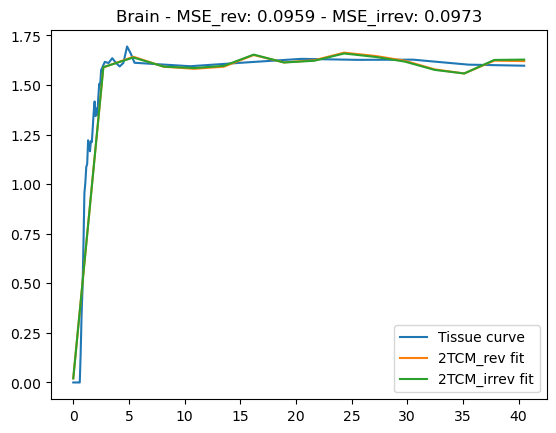

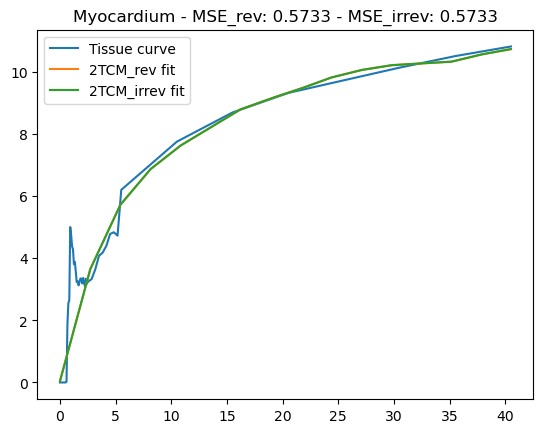

In [14]:
#Plot tissue curve and fit
tissue = "Brain"
plt.plot(VOI_t_shift, VOI_A_dict[tissue], label="Tissue curve")
plt.plot(AIF_t, twoTCMrev_dict[tissue]["tissue_fit"], label="2TCM_rev fit")
plt.plot(AIF_t, twoTCMirrev_dict[tissue]["tissue_fit"], label="2TCM_irrev fit")  
plt.title(tissue + " - MSE_rev: " + str(round(twoTCMrev_dict[tissue]["mse"],4)) + " - MSE_irrev: " + str(round(twoTCMirrev_dict[tissue]["mse"],4)))
plt.legend()
plt.show()

tissue = "Myocardium"
plt.plot(VOI_t_shift, VOI_A_dict[tissue], label="Tissue curve")
plt.plot(AIF_t, twoTCMrev_dict[tissue]["tissue_fit"], label="2TCM_rev fit")
plt.plot(AIF_t, twoTCMirrev_dict[tissue]["tissue_fit"], label="2TCM_irrev fit")
plt.title(tissue + " - MSE_rev: " + str(round(twoTCMrev_dict[tissue]["mse"],4)) + " - MSE_irrev: " + str(round(twoTCMirrev_dict[tissue]["mse"],4)))
plt.legend()
plt.show()
